## Importación de librerías

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## Cargar datos


In [2]:
df = pd.read_excel('datos/Premier League 2011-12 Match by Match.xls')
df.head()

,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,...,Pass Left,Pass Right,Unsuccessful Ball Touch,Successful Ball Touch,Take-Ons Overrun,CompId,SeasId,Touches open play final third,Touches open play opp box,Touches open play opp six yards
0,2012-04-28,28566,Abou Diaby,Vassiriki,Arsenal,3,Stoke City,110,Away,4,...,2,4,0,0,0,8,2011,2,1,0
1,2011-11-26,28566,Abou Diaby,Vassiriki,Arsenal,3,Fulham,54,Home,4,...,5,7,0,0,0,8,2011,11,1,0
2,2012-03-03,28566,Abou Diaby,Vassiriki,Arsenal,3,Liverpool,14,Away,4,...,5,3,2,0,0,8,2011,4,0,0
3,2012-04-21,28566,Abou Diaby,Vassiriki,Arsenal,3,Chelsea,8,Home,4,...,6,9,0,0,0,8,2011,8,1,0
4,2012-01-03,20208,Adam,Charlie,Liverpool,14,Manchester City,43,Away,4,...,13,12,0,4,0,8,2011,16,3,0


## Segmentación del dataframe por posición:

En la tabla de datos se pueden observar 4 tipos de posiciones diferentes (bajo el nombre 'Position Id') las cuales son: arquero (1), defensa (2), mediocampista (4) y delantero (6). Es claro que jugadores en diferentes posiciones no deben ser comparados. Adicionalmente, depende de cada posición algunas variables pierden relevancia y variabilidad (ejemplo, un delantero no puede atajar un penalti 'Penalties Saved').

### Arqueros:

#### Disminución de dimensiones:

In [3]:
df_arquero = df[df['Position Id'] == 1]
print("La posición de arquero cuenta con:", df_arquero.shape[0], "Registros diferentes.",
     "\nAdicionalmente, existen", len(df_arquero["Player ID"].unique()), "arqueros diferentes.")
df_arquero.head()

La posición de arquero cuenta con: 766 Registros diferentes. 
Adicionalmente, existen 40 arqueros diferentes.


,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,...,Pass Left,Pass Right,Unsuccessful Ball Touch,Successful Ball Touch,Take-Ons Overrun,CompId,SeasId,Touches open play final third,Touches open play opp box,Touches open play opp six yards
200,2011-10-01,28491,Al-Habsi,Ali,Wigan Athletic,111,Aston Villa,7,Away,1,...,4,1,0,0,0,8,2011,0,0,0
201,2012-04-16,28491,Al-Habsi,Ali,Wigan Athletic,111,Arsenal,3,Away,1,...,7,2,0,0,0,8,2011,0,0,0
202,2011-11-06,28491,Al-Habsi,Ali,Wigan Athletic,111,Wolverhampton Wanderers,39,Away,1,...,4,1,0,0,0,8,2011,0,0,0
203,2011-10-29,28491,Al-Habsi,Ali,Wigan Athletic,111,Fulham,54,Home,1,...,3,2,0,0,0,8,2011,0,0,0
204,2011-11-26,28491,Al-Habsi,Ali,Wigan Athletic,111,Sunderland,56,Away,1,...,5,1,0,0,0,8,2011,0,0,0


Al ser tantas variables, vamos a eliminar todas aquellas que tenga variabilidad igual a cero (probablemente los arqueros no metan goles, entre otras) y las variables que no sean numericas, es todos los casos podemos ver que está un identificador numérico equivalente al dato en texto.

In [4]:
col_eliminar = []
for col in df_arquero.columns:
    if not df_arquero[col].mad()>0:
        col_eliminar.append(col)

df_arquero.drop(col_eliminar, axis = 1, inplace = True)
print("Se han eliminado las columnas:", col_eliminar, 
      "\n reteniendo únicamente", df_arquero.shape[1], "columnas.")

Se han eliminado las columnas: ['Date', 'Player Surname', 'Player Forename', 'Team', 'Opposition', 'Venue', 'Position Id', 'Appearances', 'Winning Goal', 'Shots Off Target inc woodwork', 'Blocked Shots', 'Penalties Taken', 'Penalty Goals', 'Penalties Saved', 'Penalties Off Target', 'Penalties Not Scored', 'Direct Free-kick Goals', 'Direct Free-kick On Target', 'Direct Free-kick Off Target', 'Blocked Direct Free-kick', 'Goals from Inside Box', 'Shots On from Inside Box', 'Shots Off from Inside Box', 'Blocked Shots from Inside Box', 'Shots Off Target Outside Box', 'Blocked Shots Outside Box', 'Headed Goals', 'Headed Shots On Target', 'Headed Shots Off Target', 'Headed Blocked Shots', 'Left Foot Goals', 'Left Foot Shots On Target', 'Left Foot Shots Off Target', 'Left Foot Blocked Shots', 'Right Foot Shots Off Target', 'Right Foot Blocked Shots', 'Other Goals', 'Other Shots On Target', 'Other Shots Off Target', 'Other Blocked Shots', 'Shots Cleared off Line', 'Shots Cleared off Line Inside

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Por otro lado, se mantienen algunos datos que no deberían ser decisivos a la hora de determinar arqueros, por ejemplo los goles.

In [5]:
df_arquero[df_arquero["Goals"]>0]

,Player ID,Team Id,Opposition id,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Shots On Target inc goals,...,Pass Forward,Pass Backward,Pass Left,Pass Right,Unsuccessful Ball Touch,Successful Ball Touch,Take-Ons Overrun,Touches open play final third,Touches open play opp box,Touches open play opp six yards
4464,15337,11,30,90,1,0,0,1,1,1,...,20,0,4,2,0,0,0,0,0,0


Observamos que un arquero hizo gol en un partido (esto repercute en variables como gol, primer gol, tiros etc) por lo tanto vamos a omitir este dato y volver a eliminar columnas.

In [6]:
col_eliminar = []
for col in df_arquero.columns:
    if not df_arquero.loc[df_arquero["Goals"] == 0, col].mad()>0:
        col_eliminar.append(col)

df_arquero.drop(col_eliminar, axis = 1, inplace = True)
print("Se han eliminado las columnas:", col_eliminar, 
      "\n reteniendo únicamente", df_arquero.shape[1], "columnas.")

Se han eliminado las columnas: ['Goals', 'First Goal', 'Shots On Target inc goals', 'Goals from Outside Box', 'Shots On Target Outside Box', 'Right Foot Goals', 'Right Foot Shots On Target', 'Attempts Open Play on target'] 
 reteniendo únicamente 104 columnas.


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Ahora, agregamos los datos de cada jugador. Esto teniendo en cuenta que queremos comparar los jugadores entre si, y no por partido individual. 

In [7]:
df_arquero = df_arquero.groupby(['Player ID']).sum()
df_arquero.head()

,Team Id,Opposition id,Time Played,Starts,Substitute On,Substitute Off,Goals Open Play,Total Successful Passes All,Total Unsuccessful Passes All,Key Passes,...,Pass Forward,Pass Backward,Pass Left,Pass Right,Unsuccessful Ball Touch,Successful Ball Touch,Take-Ons Overrun,Touches open play final third,Touches open play opp box,Touches open play opp six yards
Player ID,,,,,,,,,,,,,,,,,,,,,
1344,540,676,1620,18,0,0,0,384,349,1,...,658,0,35,40,0,1,0,0,0,0
1801,170,1285,3060,34,0,0,0,367,854,4,...,1156,0,27,38,0,1,0,1,0,0
1803,228,1416,3420,38,0,0,0,828,416,1,...,816,1,166,261,1,7,0,0,0,0
1822,224,1169,2828,32,0,1,0,493,442,0,...,823,0,54,58,0,3,0,0,0,0
1827,1620,1189,2700,30,0,0,0,677,423,0,...,868,0,108,124,1,4,0,0,0,0


Por último, retiramos todas las variables categotricas o identificativas

In [8]:
df_arquero.columns

Index(['Team Id', 'Opposition id', 'Time Played', 'Starts', 'Substitute On',
       'Substitute Off', 'Goals Open Play', 'Total Successful Passes All',
       'Total Unsuccessful Passes All', 'Key Passes',
       ...
       'Pass Forward', 'Pass Backward', 'Pass Left', 'Pass Right',
       'Unsuccessful Ball Touch', 'Successful Ball Touch', 'Take-Ons Overrun',
       'Touches open play final third', 'Touches open play opp box',
       'Touches open play opp six yards'],
      dtype='object', length=103)

In [9]:
col_eliminar = ["Team Id", 'Opposition id']
df_arquero.drop(col_eliminar, axis = 1, inplace = True)

Aunque ya hemos disminuido el número de variables, claramente se debe mantener una correlación muy alta entre distintas variables (ejemplo, total pases es la suma de los pases en cada parte de la cancha). 

In [10]:
corr = df_arquero.corr()
corr.style.background_gradient(cmap = 'coolwarm')

Todavía el número de variables es demasiado alto para hacer análisis uno a uno, por lo tanto, vamos a utilizar svd para reducir dimensiones, haciendo transformaciones a espacios vectoriales más pequeños, buscando mantener el máximo de variabilidad.

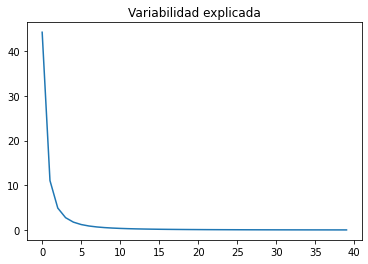

In [11]:
scaler = StandardScaler()
scaler.fit(df_arquero)
df_arquero_transformada =scaler.transform(df_arquero)

U, S, VT = svd(df_arquero_transformada, full_matrices=False)

idx = range(len(S))
func = [S[0]/((i+1) ** 2) for i in idx ]
plt.plot(idx,func) 
plt.title("Variabilidad explicada")
plt.show()

In [12]:
var_explained = np.round(S**2/np.sum(S**2), decimals=6)
num_components = 13
sum(var_explained[0:num_components])

0.9109110000000001

Podemos observar que al retener unicamente 13 componentes del espacio vectorial transformado, mantenemos más del $90\%$ de la variabilidad o información, lo cual consideramos que es bastante aceptable

In [13]:
df_arquero_transformada = df_arquero_transformada @ VT[:num_components,:].T

### agrupación de datos

Para esto, vamos a utilizar una clustering jerarquico, la principal razón de esta elección, es que no tenemos un número fijo de clusters deseables, sin embargo, queremos que haya bastantes grupos, buscando mantener un equilibrio entre la cantidad de grupos y el tamaño de los mismos.



NameError: name 'dendrogram' is not defined

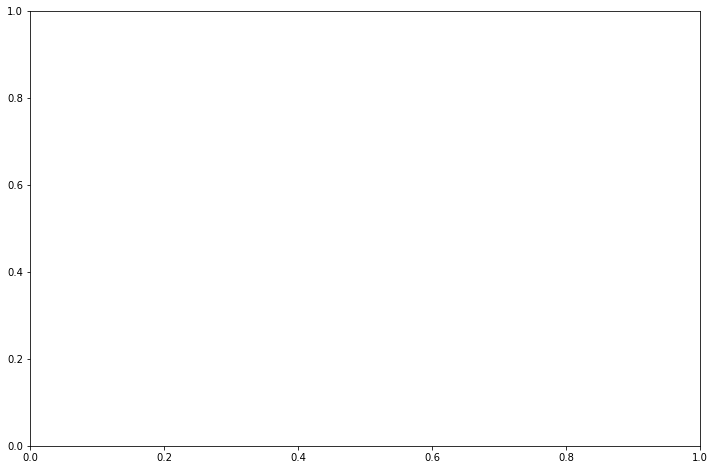

In [14]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage

dist = pdist(df_arquero_transformada, metric='euclidean')
Z = linkage(dist, method='ward')

distancia_max = 15

fig, ax = plt.subplots(figsize=(12, 8))
d = dendrogram(Z, ax=ax, color_threshold=distancia_max)
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.axhline(y=distancia_max, c='k')
plt.show()

Como se puede notar en la gráfica anterior, al delimitar una distacia máxima de 15, mantendríamos 7 grupos. Sin embargo dos grupos solo contienen un elemento. Los arqueros es la posición más dificil de agrupar debido a la cantidad de jugadores que aparecen.

In [ ]:
from scipy.cluster.hierarchy import fcluster
cluster_jerarquico = fcluster(Z, distancia_max, criterion="distance")
print("En el orden inicial, cada registro pertenecería al siguiente cluster:", cluster_jerarquico)